# CASPER example

In this jupyter notebook we will give an example of how some of the functions contained with Casper can be used to predict the concentration and shape parameter for a given cosmology as a function of mass and redshift. Additional functions can be used to plot the resulting density and circular velocity profiles. For a detailed description of the model and how it was developed see the original [paper](arxiv_link).

First let us import the necessary module. For this tutorial you will need to have the following modules installed (if using binder these will automatically be available):

- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)
- [PyCAMB](https://camb.readthedocs.io/en/latest/) (Any method that reliably predicts the linear power spectra can be used, here we use CAMB)
- [Casper]()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casper import casper
import camb

First let us define the cosmological variables we are using. In this example we are going to use the Planck 2018 best fit LCDM parameters. Here we have used k_pivot and A_s to normalise the power spectrum correctly, these are the inputs that CAMB requires as well as being the values presented in the Plank 2018 results. However, it is common to normalise the power spectrum using sigma_8. We discuss how to do this in the [Appendix](#appendix).

In [2]:
ns = 0.967
A_s = 2.105*10**(-9)
k_pivot = 0.05
omega_ch2 = 0.119
omega_bh2 = 0.0224

h = 0.677 
omega_m = omega_ch2/h**2 + omega_bh2/h**2
rho_crit = casper.Critical_density()    # calculate the critical density, in units of h^2 M_sun Mpc^-1

Now that we have defined the appropriate cosmological parameters we can generate the linear power spectra at the redshifts we want. Here we are going to look at z=0, 1 and 2.

Be aware that this cell will take a while to run, due to the high k-scale we have asked CAMB to calculate the linear power spectrum to. For your own code it may be worth running camb once 
and writing the power spectrum output (e.g., as a text file).


In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0 = h*100, ombh2 = omega_bh2, omch2 = omega_ch2)
pars.InitPower.set_params(ns = ns, As = A_s, pivot_scalar = k_pivot)
pars.set_matter_power(redshifts = [2.0, 1.0, 0.0],kmax = 1e3/h)
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh = 1e-3, maxkh = 1e3, npoints = 1000)


We can have a quick look at what the power spectra for this cosmology looks like.

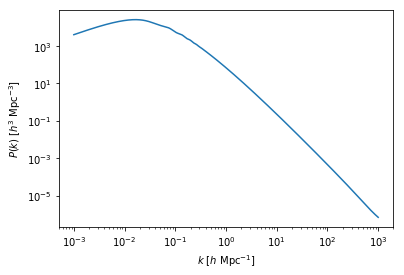

In [18]:
plt.figure()
plt.plot(kh, pk[0,:])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel('$P(k)$ [$h^3$ Mpc$^{-3}$]')

With the background cosmological parameters set and the power spectra generated we can now use CASPER to predict c and alpha for the masses we want.

In [5]:
#define mass range (in M_200c [h^-1 M_sun]) to calculate the density paramters
M=np.logspace(12,14,100)

c0,alpha0=casper.casper(M, np.vstack((kh, pk[0,:])).T, omega_m, return_peak_height=False)
c1,alpha1=casper.casper(M, np.vstack((kh, pk[1,:])).T, omega_m, return_peak_height=False)
c2,alpha2=casper.casper(M, np.vstack((kh, pk[2,:])).T, omega_m, return_peak_height=False) 

If we had wanted to know the resulting peak height values used to model c and alpha we just needed to set the keyword 'return_peak_height' to True. The function would then return (c, alpha, nu_c, nu_alpha).

Let us now plot the resulting concentration and shape parameter mass relations for z=0, 1 and 2.

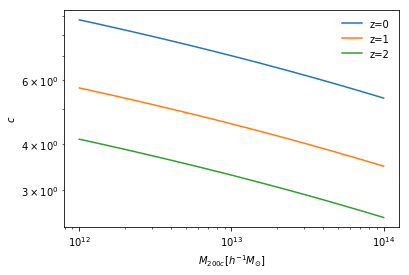

In [6]:
plt.figure()
plt.plot(M, c0, label='z=0')
plt.plot(M, c1, label='z=1')
plt.plot(M, c2, label='z=2')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_{200c} [h^{-1} M_{\\odot}]$')
plt.ylabel('$c$')
plt.legend(frameon=False)

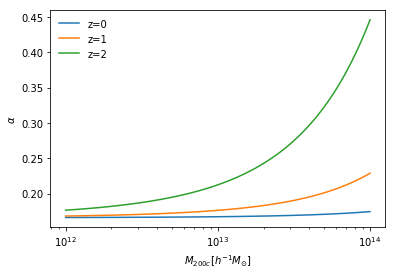

In [7]:
plt.figure()
plt.plot(M, alpha0, label='z=0')
plt.plot(M, alpha1, label='z=1')
plt.plot(M, alpha2, label='z=2')

plt.xscale('log')

plt.xlabel('$M_{200c} [h^{-1} M_{\\odot}]$')
plt.ylabel('$\\alpha$')
plt.legend(frameon=False)

As well as using CASPER to generate the concentration and shape parameter for the given cosmology, redshift and mass (which is the primary use of the module) we can also plot what the resulting circular velocity and density profiles look like.

Let's compare a 10^12 to a 10^15 h^-1 M_sun mass halo for the same cosmology at z=0.

First we need to calculate the values of c and alpha for these haloes.


In [8]:
M200 = np.array([10**12, 10**15])
R200 = (M200 /(200*rho_crit*4/3*np.pi))**(1/3) # need to calculate the size of the halo, which we use later

c,alpha = casper.casper(M200, np.vstack((kh, pk[0,:])).T, omega_m, return_peak_height=False)

We also need to define the radial range (in units of R200c) that we want to plot over.

In [9]:
r = np.logspace(-1,0,100)

To be able to plot the resulting Einasto profiles we need to know the normalisation, rho_2. This can be constrained by ensuring that the integrated mass of the density profile is indeed the mass of the halo. We can calculate the mass within a given radius using the function *Einasto_mass*(r, rho_2, c, alpha, R200).

In [10]:
rho_2 = np.empty(len(M200))
for i in range(len(M200)):
    rho_2[i] = M200[i] /casper.Einasto_mass(1, 1, c[i], alpha[i], R200[i]) 
    

We can now plot the resulting circular velocity and density profiles.

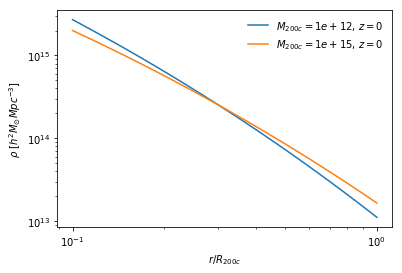

In [11]:
plt.figure()
for i in range(len(M200)):
    rho = casper.Einasto_density(r, rho_2[i], c[i], alpha0[i])
    plt.plot(r, rho, label='$M_{200c}=%.0e$, $z=0$'% M200[i])

plt.xlabel('$r/R_{200c}$')
plt.ylabel('$\\rho$ $[h^2 M_{\\odot} Mpc^{-3}]$')
plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')

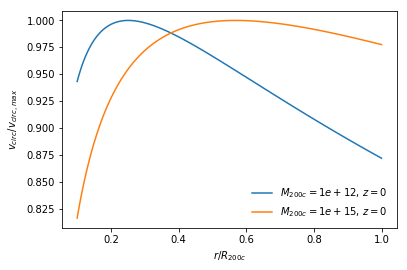

In [12]:
plt.figure()
for i in range(len(M200)):
    #We do not need the factor of G here as we will normalise by the maximum circular velocity
    v_circ = np.sqrt( casper.Einasto_mass(r, rho_2[i], c[i], alpha0[i], R200[i]) /r)
    plt.plot(r, v_circ/np.max(v_circ), label='$M_{200c}=%.0e$, $z=0$'% M200[i])

plt.xlabel('$r/R_{200c}$')
plt.ylabel('$v_{circ}/v_{circ,max}$')
plt.legend(frameon=False)


The above example covers most of the useful functionality of casper. With the main function being casper(), that predicts c and alpha. The functionality of the module is relatively straightforward and is essentially a collection of functions that can be used to calculate density profiles and peak height values for a given cosmology. A full list of the available functions with basic documentation can be found with the following.

In [13]:
help(casper)

Help on module casper.casper in casper:

NAME
    casper.casper

FUNCTIONS
    Critical_density()
        Function to calucalte the critical density, in units of h^2 M_sun Mpc^-3
    
    Einasto_density(r, rho_s, c, alpha)
        Function to generate an Einasto density profile
    
    Einasto_mass(r, rho_s, c, alpha, R200)
        Function to generate the integrated mass, as a funciton of radius, for an Einasto profile
    
    casper(M, pk, omega_m, return_peak_height=False)
        Function to calculate the concentration and shape parameter for a given 
        mass, redshift and cosmology.
        
        Parameters:
        
        
        M (array_like): The masses at which to calculate the shape parameters.
        Assumes the mass is M_200c in  units of h^-1 M_sun.
        
        pk (2d array): The linear power spectrum for the given cosmology. Assumes
        pk[:,0] is k while pk[:,1]  is P(k). Units are assumed to be h Mpc^-1 for
        k while h^3Mpc^-3 for P(k)
   

If you have any issues or questions then please feel free to contact me at S.T.Brown@2018.ljmu.ac.uk.

Additionally, if the results of this model to predict c and alpha are used in any published work can you please cite the [paper](link) appropriately.

<a id='appendix'></a>

## Appendix

In this section we discuss how you can use CAMB to normalise the power spectrum with respect to a given value of sigma_8. We first need to select a choice of A_s and k_pivot and the sigma_8 value we want. These could in principle be any values, though it's best to select something not too extreme and close to those above to avoid rounding errors, etc.

In [14]:
A_s_1 = 10**(-9)
k_pivot = 0.05
sigma_8 = 0.8 

Here we have used the plack pivot point, and a value of A_s that is roughly the correct order of magnitude to what we expect. Next we need to calculate what sigma_8 is for this particular cosmology.

In [15]:
pars = camb.CAMBparams()
pars.set_cosmology(H0 = h*100, ombh2 = omega_bh2, omch2 = omega_ch2)
pars.InitPower.set_params(ns = ns, As = A_s_1, pivot_scalar = k_pivot)
pars.set_matter_power(redshifts = [0.0],kmax = 2)
results = camb.get_results(pars)

sigma_8_1 = results.get_sigma8()
print(sigma_8_1)

[0.55756601]


Here we see that for the cosmology we've chosen the sigma_8~0.5, representing a universe with less structure than we observe in our own. This value is close to what we want, though a little lower. We can use the fact that sigma_8 is proportional to (A_s)^0.5 to calculate the value of A_s that will give us sigma_8=0.8.

In [16]:
A_s = A_s_1 * (sigma_8 /sigma_8_1)**2

We can then rerun camb with all the same parameters, except now using the properly normalised value for A_s, to generate the correctly normalised power spectrum. We can also confirm that we do indeed recover the value of sigma_8 we want.

In [17]:
pars = camb.CAMBparams()
pars.set_cosmology(H0 = h*100, ombh2 = omega_bh2, omch2 = omega_ch2)
pars.InitPower.set_params(ns = ns, As = A_s, pivot_scalar = k_pivot)
pars.set_matter_power(redshifts = [0.0],kmax = 2)
results = camb.get_results(pars)

print(results.get_sigma8())

[0.8]
